## Data Balance Analysis using the Adult Census Income dataset

In this example, we will conduct Data Balance Analysis (which consists on running three groups of measures) on the Adult Census Income dataset to determine how well features and feature values are represented in the dataset.

This dataset can be used to predict whether annual income exceeds $50,000/year or not based on demographic data from the 1994 U.S. Census. The dataset we're reading contains 32,561 rows and 14 columns/features.

[More info on the dataset here](https://archive.ics.uci.edu/ml/datasets/Adult)

---

Data Balance Analysis is relevant for overall understanding of datasets, but it becomes essential when thinking about building Machine Learning services out of such datasets. Having a well balanced data representation is critical when developing models in a responsible way, specially in terms of fairness. 
It is unfortunately all too easy to build an ML model that produces biased results for subsets of an overall population, by training or testing the model on biased ground truth data. There are multiple case studies of biased models assisting in granting loans, healthcare, recruitment opportunities and many other decision making tasks. In most of these examples, the data from which these models are trained was the common issue. These findings emphasize how important it is for model creators and auditors to analyze data balance: to measure training data across sub-populations and ensure the data has good coverage and a balanced representation of labels across sensitive categories and category combinations, and to check that test data is representative of the target population.

In summary, Data Balance Analysis, used as a step for building ML models has the following benefits:
* **Reduces risks for unbalanced models (facilitate service fairness) and reduces costs of ML building** by identifying early on data representation gaps that prompt data scientists to seek mitigation steps (collect more data, follow a specific sampling mechanism, create synthetic data, etc.) before proceeding to train their models. 
* **Enables easy e2e debugging of ML systems** in combination with [Fairlearn](https://fairlearn.org/) by providing a clear view if for an unbalanced model the issue is tied to the data or the model. 

---

Note: If you are running this notebook in a Spark environment such as Azure Synapse or Databricks, then you can easily visualize the imbalance measures using the built-in plotting features.

Python dependencies:
* matplotlib==3.2.2
* numpy==1.19.2

In [ ]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pyspark.sql.functions as F

In [ ]:
df = spark.read.parquet("wasbs://publicwasb@mmlspark.blob.core.windows.net/AdultCensusIncome.parquet")
display(df)

In [ ]:
# Convert the "income" column from {<=50K, >50K} to {0, 1} to represent our binary classification label column
label_col = "income"
df = df.withColumn(label_col, F.when(F.col(label_col).contains("<=50K"), F.lit(0)).otherwise(F.lit(1)))

### Perform preliminary analysis on columns of interest

In [ ]:
display(df.groupBy("race").count())

In [ ]:
display(df.groupBy("sex").count())

In [ ]:
# Choose columns/features to do data balance analysis on
cols_of_interest = ["race", "sex"]
display(df.select(cols_of_interest + [label_col]))

### Calculate Feature Balance Measures

Feature Balance Measures allow us to see whether each combination of sensitive feature is receiving the positive outcome (true prediction) at equal rates.

In this context, we define a feature balance measure, also referred to as the parity, for label y as the absolute difference between the association metrics of two different sensitive classes \\([x_A, x_B]\\), with respect to the association metric \\(A(x_i, y)\\). That is:

$$parity(y \vert x_A, x_B, A(\cdot)) \coloneqq A(x_A, y) - A(x_B, y) $$

Using the dataset, we can see if the various sexes and races are receiving >50k income at equal or unequal rates.

Note: Many of these metrics were influenced by this paper [Measuring Model Biases in the Absence of Ground Truth](https://arxiv.org/abs/2103.03417).

Measure | Family | Description | Interpretation/Formula | Reference
- | - | - | - | -
Demographic Parity | Fairness | Proportion of each segment of a protected class (e.g. gender) should receive the positive outcome at equal rates. | As close to 0 means better parity. \\(DP = P(Y \vert A = "Male") - P(Y \vert A = "Female")\\). Y = Positive label rate. | [Link](https://en.wikipedia.org/wiki/Fairness_%28machine_learning%29)
Pointwise Mutual Information (PMI), normalized PMI | Entropy | The PMI of a pair of feature values (ex: Gender=Male and Gender=Female) quantifies the discrepancy between the probability of their coincidence given their joint distribution and their individual distributions (assuming independence). | Range (normalized) [-1, 1]. -1 for no co-occurences. 0 for co-occurences at random. 1 for complete co-occurences. | [Link](https://en.wikipedia.org/wiki/Pointwise_mutual_information)
Sorensen-Dice Coefficient (SDC) | Intersection-over-Union | Used to gauge the similarity of two samples. Related to F1 score. | Equals twice the number of elements common to both sets divided by the sum of the number of elements in each set. | [Link](https://en.wikipedia.org/wiki/S%C3%B8rensen%E2%80%93Dice_coefficient)
Jaccard Index | Intersection-over-Union | Similar to SDC, guages the similarity and diversity of sample sets. | Equals the size of the intersection divided by the size of the union of the sample sets. | [Link](https://en.wikipedia.org/wiki/Jaccard_index)
Kendall Rank Correlation | Correlation and Statistical Tests | Used to measure the ordinal association between two measured quantities. | High when observations have a similar rank and low when observations have a dissimilar rank between the two variables. | [Link](https://en.wikipedia.org/wiki/Kendall_rank_correlation_coefficient)
Log-Likelihood Ratio | Correlation and Statistical Tests | Calculates the degree to which data supports one variable versus another. Log of the likelihood ratio, which gives the probability of correctly predicting the label in ratio to probability of incorrectly predicting label. | If likelihoods are similar, it should be close to 0. | [Link](https://en.wikipedia.org/wiki/Likelihood_function#Likelihood_ratio)
t-test | Correlation and Statistical Tests | Used to compare the means of two groups (pairwise). | Value looked up in t-Distribution tell if statistically significant or not. | [Link](https://en.wikipedia.org/wiki/Student's_t-test)

In [ ]:
from synapse.ml.exploratory import FeatureBalanceMeasure

feature_balance_measures = (
    FeatureBalanceMeasure()
    .setSensitiveCols(cols_of_interest)
    .setLabelCol(label_col)
    .setVerbose(True)
    .transform(df)
)

# Sort by Demographic Parity descending for all features
display(feature_balance_measures.sort(F.abs("FeatureBalanceMeasure.dp").desc()))

In [ ]:
# Drill down to feature == "sex"
display(feature_balance_measures.filter(F.col("FeatureName") == "sex").sort(F.abs("FeatureBalanceMeasure.dp").desc()))

In [ ]:
# Drill down to feature == "race"
display(feature_balance_measures.filter(F.col("FeatureName") == "race").sort(F.abs("FeatureBalanceMeasure.dp").desc()))

#### Visualize Feature Balance Measures

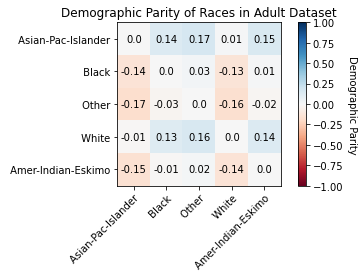

In [ ]:
races = [row["race"] for row in df.groupBy("race").count().select("race").collect()]
dp_rows = feature_balance_measures.filter(F.col("FeatureName") == "race").select("ClassA", "ClassB", "FeatureBalanceMeasure.dp").collect()
race_dp_values = [(row["ClassA"], row["ClassB"], row["dp"]) for row in dp_rows]

race_dp_array = np.zeros((len(races), len(races)))
for class_a, class_b, dp_value in race_dp_values:
  i, j = races.index(class_a), races.index(class_b)
  dp_value = round(dp_value, 2)
  race_dp_array[i, j] = dp_value
  race_dp_array[j, i] = -1 * dp_value

colormap = "RdBu"
dp_min, dp_max = -1.0, 1.0

fig, ax = plt.subplots()
im = ax.imshow(race_dp_array, vmin=dp_min, vmax=dp_max, cmap=colormap)

cbar = ax.figure.colorbar(im, ax=ax)
cbar.ax.set_ylabel("Demographic Parity", rotation=-90, va="bottom")

ax.set_xticks(np.arange(len(races)))
ax.set_yticks(np.arange(len(races)))
ax.set_xticklabels(races)
ax.set_yticklabels(races)

plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")

for i in range(len(races)):
  for j in range(len(races)):
    text = ax.text(j, i, race_dp_array[i, j], ha="center", va="center", color="k")
    
ax.set_title("Demographic Parity of Races in Adult Dataset")
fig.tight_layout()
plt.show()

#### Interpret Feature Balance Measures

Demographic Parity:
* When it is positive, it means that ClassA sees the positive outcome more than ClassB.
* When it is negative, it means that ClassB sees the positive outcome more than ClassA.

---

From the results, we can tell the following:

For Sex:
* DP(Male, Female) = 0.1963 shows "Male" observations are associated with ">50k" income label more often than "Female" observations.

For Race:
* DP(Other, Asian-Pac-Islander) = -0.1734 shows "Other" observations are associated with ">50k" income label less than "Asian-Pac-Islander" observations.
* DP(White, Other) = 0.1636 shows "White" observations are associated with ">50k" income label more often than "Other" observations.
* DP(Asian-Pac-Islander, Amer-Indian-Eskimo) = 0.1494 shows "Asian-Pac-Islander" observations are associated with ">50k" income label more often than "Amer-Indian-Eskimo" observations.

Again, you can take mitigation steps to upsample/downsample your data to be less biased towards certain features and feature values.

Built-in mitigation steps are coming soon.

### Calculate Distribution Balance Measures

Distribution Balance Measures allow us to compare our data with a reference distribution (i.e. uniform distribution). They are calculated per sensitive column and don't use the label column.

For example, let's assume we have a dataset with 9 rows and a Gender column, and we observe that:
* "Male" appears 4 times
* "Female" appears 3 times
* "Other" appears 2 times

Assuming the uniform distribution:
$$ReferenceCount \coloneqq  \frac{numRows}{numFeatureValues}$$
$$ReferenceProbability \coloneqq  \frac{1}{numFeatureValues}$$

Feature Value | Observed Count | Reference Count | Observed Probability | Reference Probabiliy
- | - | - | - | -
Male | 4 | 9/3 = 3 | 4/9 = 0.44 | 3/9 = 0.33
Female | 3 | 9/3 = 3 | 3/9 = 0.33 | 3/9 = 0.33
Other | 2 | 9/3 = 3 | 2/9 = 0.22 | 3/9 = 0.33

We can use distance measures to find out how far our observed and reference distributions of these feature values are. Some of these distance measures include:

Measure | Description | Interpretation | Reference
- | - | - | -
KL Divergence | Measure of how one probability distribution is different from a second, reference probability distribution. Measure of the information gained when one revises one's beliefs from the prior probability distribution Q to the posterior probability distribution P. In other words, it is the amount of information lost when Q is used to approximate P. | Non-negative. 0 means P = Q. | [Link](https://en.wikipedia.org/wiki/Kullback%E2%80%93Leibler_divergence)
JS Distance | Measuring the similarity between two probability distributions. Symmetrized and smoothed version of the Kullback–Leibler (KL) divergence. Square root of JS Divergence. | Range [0, 1]. 0 means perfectly same to balanced distribution. | [Link](https://en.wikipedia.org/wiki/Jensen%E2%80%93Shannon_divergence)
Wasserstein Distance | This distance is also known as the earth mover’s distance, since it can be seen as the minimum amount of “work” required to transform u into v, where “work” is measured as the amount of distribution weight that must be moved, multiplied by the distance it has to be moved. | Non-negative. 0 means P = Q. | [Link](https://en.wikipedia.org/wiki/Wasserstein_metric)
Infinity Norm Distance | Distance between two vectors is the greatest of their differences along any coordinate dimension. Also called Chebyshev distance or chessboard distance. | Non-negative. 0 means same distribution. | [Link](https://en.wikipedia.org/wiki/Chebyshev_distance)
Total Variation Distance | It is equal to half the L1 (Manhattan) distance between the two distributions. Take the difference between the two proportions in each category, add up the absolute values of all the differences, and then divide the sum by 2. | Non-negative. 0 means same distribution. | [Link](https://en.wikipedia.org/wiki/Total_variation_distance_of_probability_measures)
Chi-Squared Test | The chi-square test tests the null hypothesis that the categorical data has the given frequencies given expected frequencies in each category. | p-value gives evidence against null-hypothesis that difference in observed and expected frequencies is by random chance. | [Link](https://en.wikipedia.org/wiki/Chi-squared_test)

In [ ]:
from synapse.ml.exploratory import DistributionBalanceMeasure

distribution_balance_measures = (
    DistributionBalanceMeasure()
   .setSensitiveCols(cols_of_interest)
   .transform(df)
)

# Sort by JS Distance descending
display(distribution_balance_measures.sort(F.abs("DistributionBalanceMeasure.js_dist").desc()))

#### Visualize Distribution Balance Measures

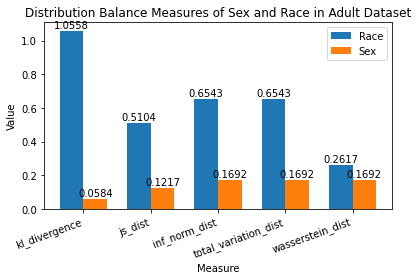

In [ ]:
distribution_rows = distribution_balance_measures.collect()
race_row = [row for row in distribution_rows if row["FeatureName"] == "race"][0]["DistributionBalanceMeasure"]
sex_row = [row for row in distribution_rows if row["FeatureName"] == "sex"][0]["DistributionBalanceMeasure"]

measures_of_interest = ["kl_divergence", "js_dist", "inf_norm_dist", "total_variation_dist", "wasserstein_dist"]
race_measures = [round(race_row[measure], 4) for measure in measures_of_interest]
sex_measures = [round(sex_row[measure], 4) for measure in measures_of_interest]

x = np.arange(len(measures_of_interest))
width = 0.35

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, race_measures, width, label="Race")
rects2 = ax.bar(x + width/2, sex_measures, width, label="Sex")

ax.set_xlabel("Measure")
ax.set_ylabel("Value")
ax.set_title("Distribution Balance Measures of Sex and Race in Adult Dataset")
ax.set_xticks(x)
ax.set_xticklabels(measures_of_interest)
ax.legend()

plt.setp(ax.get_xticklabels(), rotation=20, ha="right", rotation_mode="default")

def autolabel(rects):
  for rect in rects:
    height = rect.get_height()
    ax.annotate('{}'.format(height),
                xy=(rect.get_x() + rect.get_width() / 2, height),
                xytext=(0, 1),  # 1 point vertical offset
                textcoords="offset points",
                ha='center', va='bottom')

autolabel(rects1)
autolabel(rects2)

fig.tight_layout()

plt.show()

#### Interpret Distribution Balance Measures

Race has a JS Distance of 0.5104 while Sex has a JS Distance of 0.1217.

Knowing that JS Distance is between [0, 1] where 0 means perfectly balanced distribution, we can tell that:
* There is a larger disparity between various races than various sexes in our dataset.
* Race is nowhere close to a perfectly balanced distribution (i.e. some races are seen ALOT more than others in our dataset).
* Sex is fairly close to a perfectly balanced distribution.

### Calculate Aggregate Balance Measures

Aggregate Balance Measures allow us to obtain a higher notion of inequality. They are calculated on the global set of sensitive columns and don't use the label column.

These measures look at distribution of records across all combinations of sensitive columns. For example, if Sex and Race are sensitive columns, it shall try to quantify imbalance across all combinations - (Male, Black), (Female, White), (Male, Asian-Pac-Islander), etc.

Measure | Description | Interpretation | Reference
- | - | - | -
Atkinson Index | It presents the percentage of total income that a given society would have to forego in order to have more equal shares of income between its citizens. This measure depends on the degree of society aversion to inequality (a theoretical parameter decided by the researcher), where a higher value entails greater social utility or willingness by individuals to accept smaller incomes in exchange for a more equal distribution. An important feature of the Atkinson index is that it can be decomposed into within-group and between-group inequality. | Range [0, 1]. 0 if perfect equality. 1 means maximum inequality. In our case, it is the proportion of records for a sensitive columns’ combination. | [Link](https://en.wikipedia.org/wiki/Atkinson_index)
Theil T Index | GE(1) = Theil's T and is more sensitive to differences at the top of the distribution. The Theil index is a statistic used to measure economic inequality. The Theil index measures an entropic "distance" the population is away from the "ideal" egalitarian state of everyone having the same income. | If everyone has the same income, then T_T equals 0. If one person has all the income, then T_T gives the result (ln N). 0 means equal income and larger values mean higher level of disproportion. | [Link](https://en.wikipedia.org/wiki/Theil_index)
Theil L Index | GE(0) = Theil's L and is more sensitive to differences at the lower end of the distribution. Logarithm of (mean income)/(income i), over all the incomes included in the summation. It is also referred to as the mean log deviation measure. Because a transfer from a larger income to a smaller one will change the smaller income's ratio more than it changes the larger income's ratio, the transfer-principle is satisfied by this index. | Same interpretation as Theil T Index. | [Link](https://en.wikipedia.org/wiki/Theil_index)

In [ ]:
from synapse.ml.exploratory import AggregateBalanceMeasure

aggregate_balance_measures = (
    AggregateBalanceMeasure()
    .setSensitiveCols(cols_of_interest)
    .transform(df)
)

display(aggregate_balance_measures)

#### Interpret Aggregate Balance Measures

An Atkinson Index of 0.7779 lets us know that 77.79% of data points need to be foregone to have a more equal share among our features.

It lets us know that our dataset is leaning towards maximum inequality, and we should take actionable steps to:
* Upsample data points where the feature value is barely observed.
* Downsample data points where the feature value is observed much more than others.

### Summary

Throughout the course of this sample notebook, we have:
1. Chosen "Race" and "Sex" as columns of interest in the Adult Census Income dataset.
2. Done preliminary analysis on our dataset. 
3. Ran the 3 groups of measures that compose our **Data Balance Analysis**:
  * **Feature Balance Measures**
    * Calculated Feature Balance Measures to see that the highest Demographic Parity is in "Sex": Males see >50k income much more than Females.
    * Visualized Demographic Parity of Races to see that Asian-Pac-Islander sees >50k income much more than Other, in addition to other race combinations.
  * **Distribution Balance Measures** 
    * Calculated Distribution Balance Measures to see that "Sex" is much closer to a perfectly balanced distribution than "Race".
    * Visualized various distribution balance measures to compare their values for "Race" and "Sex".
  * **Aggregate Balance Measures**
    * Calculated Aggregate Balance Measures to see that we need to forego 77.79% of data points to have a perfectly balanced dataset. We identified that our dataset is leaning towards maximum inequality, and we should take actionable steps to:
    * Upsample data points where the feature value is barely observed.
    * Downsample data points where the feature value is observed much more than others.
    
**In conclusion:**
* These measures provide an indicator of disparity on the data, allowing for users to explore potential mitigations before proceeding to train. 
* Users can use these measures to set thresholds on their level of "tolerance" for data representation.
* Production pipelines can use these measures as baseline for models that require frequent retraining on new data. 
* These measures can also be saved as key metadata for the model/service built and added as part of model cards or transparency notes helping drive overall accountability for the ML service built and its performance across different demographics or sensitive attributes.